# Imports

In [1]:
# Time and Others
import time
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import math
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, GlobalMaxPool1D
from collections import Counter

# Web Scraping
import requests 
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

# Stopwords
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import wordcloud as wc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
stopwrds = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

# Google Drive Connections

In [3]:
# Preston/Carson's import
from google.colab import drive
drive.mount('/content/drive')
% cd "/content/drive/MyDrive/CS5830/Final Project"

Mounted at /content/drive
/content/drive/MyDrive/CS5830/Final Project


# Final Database Analyses

In [4]:
stopwrds = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess_review(df_orig):
  df = df_orig.copy()

  # lowercase
  df["review_text"] = df["review_text"].str.lower()

  # remove urls
  df['review_text'] = df['review_text'].apply(lambda x: re.sub(r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)", "", x))

  # remove punctuation
  df['review_text'] = df['review_text'].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))

  # tokenize
  df['review_text'] = df['review_text'].str.split()

  # lemmatize text
  df['review_text'] = df['review_text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])

  # remove stop words
  df['review_text'] = df['review_text'].apply(lambda x: [i for i in x if i not in stopwrds])

  # return back to normal string
  df['review_text'] = df['review_text'].apply(lambda x: ' '.join(x))

  return df

df = pd.read_csv('merged_database.csv')
df.dropna(subset=['review_text'], inplace=True)
df = preprocess_review(df)
df.head()

,app,review_text,review_sentiment,store
0,"!""We Are The Dwarves""!",pretty nice innovative interesting blend defin...,1,steam
1,#SelfieTennis,tennis court house watch lamp hanging ceiling ...,1,steam
2,0RBITALIS,gamer gourment choose game second review steam...,1,steam
3,1 Moment Of Time: Silentville,alright first review think 1 moment time hidde...,1,steam
4,10 Second Ninja,wa like try see demo buying wa demo youtube vi...,-1,steam


In [5]:
len(df)

60888

In [6]:
psDB = df[df['store']=='google_play'].copy()
steamDB = df[df['store']=='steam'].copy()

## Label Distribution

In [7]:
psDB.head()

,app,review_text,review_sentiment,store
50384,com.anydo,cannot open app anymore,-1,google_play
50385,com.anydo,begging refund app month nobody replying,-1,google_play
50386,com.anydo,costly premium version approx indian rupee 910...,-1,google_play
50387,com.anydo,used keep organized 2020 update made mess thin...,-1,google_play
50388,com.anydo,dan birthday oct 28,-1,google_play


### Play Store Data

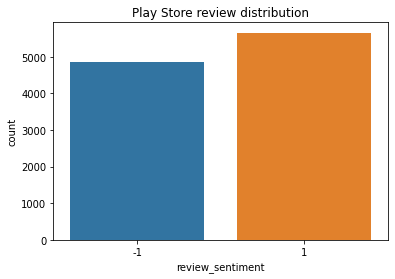

In [8]:
psDB_by_label = psDB.groupby('review_sentiment').size().reset_index(name='count')
psDB_by_label = psDB_by_label.sort_values("count", ascending=False)
plt.title("Play Store review distribution")
sns.barplot(x='review_sentiment', y='count', data=psDB_by_label)

### Steam Data

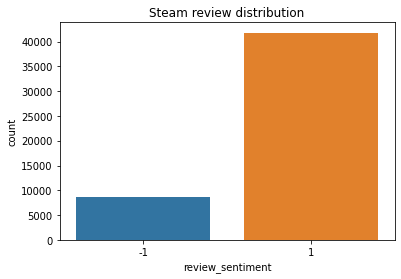

In [9]:
steamDB_by_label = steamDB.groupby('review_sentiment').size().reset_index(name='count')
steamDB_by_label = steamDB_by_label.sort_values("count", ascending=False)
plt.title("Steam review distribution")
sns.barplot(x='review_sentiment', y='count', data=steamDB_by_label)

## Word Clouds

App Name: cc.forestapp
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




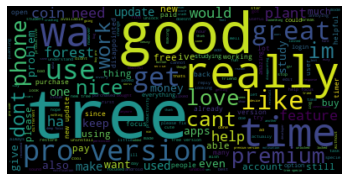

App Name: com.anydo
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




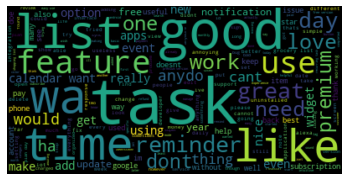

App Name: com.appgenix.bizcal
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




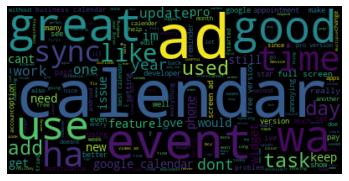

App Name: com.appxy.planner
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




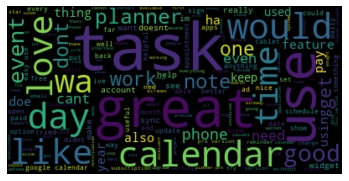

App Name: com.gmail.jmartindev.timetune
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




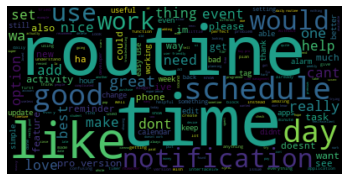

App Name: com.habitrpg.android.habitica
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




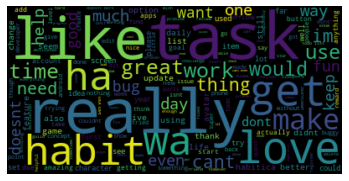

App Name: com.microsoft.todos
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




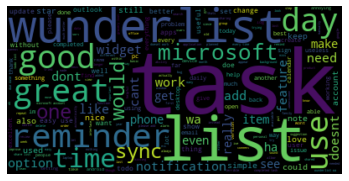

App Name: com.oristats.habitbull
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




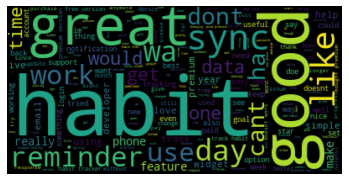

App Name: com.ticktick.task
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




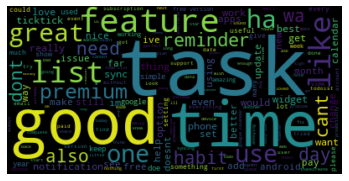

App Name: com.todoist
Number of Positive Sentiment: 400
Number of Negative Sentiment: 400
Number of Total Reviews: 800




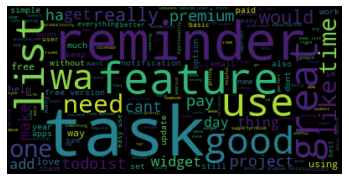

In [10]:
# Word Clouds for top 10 Google Play Apps (in numbers of reviews)
tenLargest = psDB.groupby('app').size().sort_values().nlargest(10)
grouping = psDB.groupby('app')

top10db = {
    'x': [],
    'y': [],
    'group': []
}

# Create stopword list:
stopwords = set(stopwords.words('english'))
stopwords.update(["br", "href", "app"])

# Loop through all the 10 largest games and see how many positive reviews they have
for key in tenLargest.keys():
  df = grouping.get_group(name=key)
  top10db['x'].append(key)
  top10db['x'].append(key)
  top10db['y'].append(len(df[df.review_sentiment == 1]))
  top10db['y'].append(len(df[df.review_sentiment == -1]))
  top10db['group'].append('reviews with positive sentiment')
  top10db['group'].append('reviews with negative sentiment')

  print(f'App Name: {key}')
  print(f'Number of Positive Sentiment: {len(df[df.review_sentiment == 1])}')
  print(f'Number of Negative Sentiment: {len(df[df.review_sentiment == -1])}')
  print(f'Number of Total Reviews: {len(df.review_sentiment)}')
  print("\n")

  # Print out words that are most present in each game's reviews
  textt = " ".join(str(review) for review in df.review_text)
  wordcloud = wc.WordCloud(stopwords=stopwords).generate(textt)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  # plt.savefig('wordcloud11.png')
  plt.show()

App Name: PAYDAY 2
Number of Positive Sentiment: 594
Number of Negative Sentiment: 264
Number of Total Reviews: 858




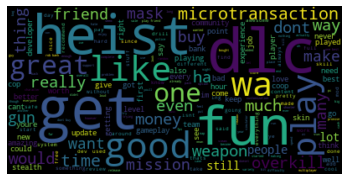

App Name: Terraria
Number of Positive Sentiment: 793
Number of Negative Sentiment: 29
Number of Total Reviews: 822




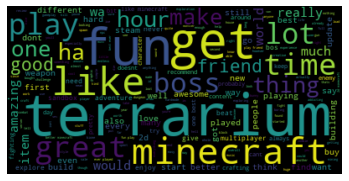

App Name: Dota 2
Number of Positive Sentiment: 604
Number of Negative Sentiment: 107
Number of Total Reviews: 711




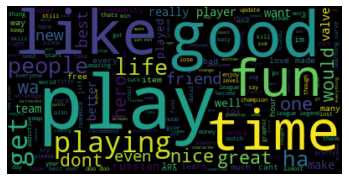

App Name: Rocket League
Number of Positive Sentiment: 488
Number of Negative Sentiment: 38
Number of Total Reviews: 526




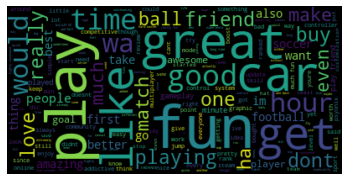

App Name: Undertale
Number of Positive Sentiment: 486
Number of Negative Sentiment: 18
Number of Total Reviews: 504




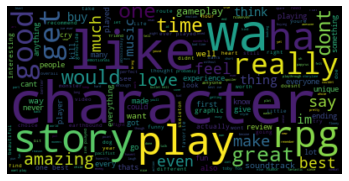

App Name: Left 4 Dead 2
Number of Positive Sentiment: 450
Number of Negative Sentiment: 44
Number of Total Reviews: 494




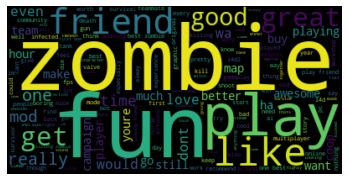

App Name: Warframe
Number of Positive Sentiment: 424
Number of Negative Sentiment: 43
Number of Total Reviews: 467




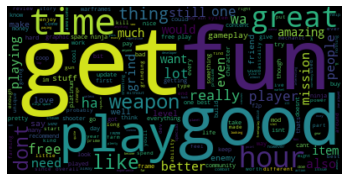

App Name: Grand Theft Auto V
Number of Positive Sentiment: 306
Number of Negative Sentiment: 105
Number of Total Reviews: 411




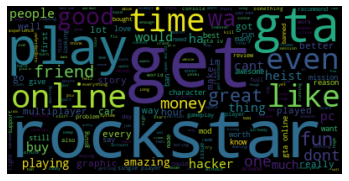

App Name: Portal 2
Number of Positive Sentiment: 370
Number of Negative Sentiment: 5
Number of Total Reviews: 375




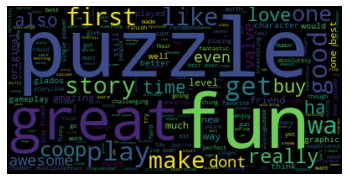

App Name: Fallout: New Vegas
Number of Positive Sentiment: 309
Number of Negative Sentiment: 11
Number of Total Reviews: 320




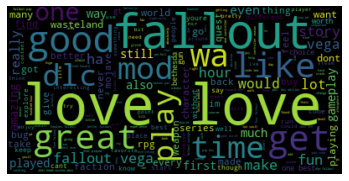

In [11]:
# Word Clouds for top 10 Steam (in numbers of reviews)
tenLargest = steamDB.groupby('app').size().sort_values().nlargest(10)
grouping = steamDB.groupby('app')

top10db = {
    'x': [],
    'y': [],
    'group': []
}

# Create stopword list:
# stopwords = set(stopwords.words('english'))
stopwords.update(["br", "href","game"])

# Loop through all the 10 largest games and see how many positive reviews they have
for key in tenLargest.keys():
  df = grouping.get_group(name=key)
  top10db['x'].append(key)
  top10db['x'].append(key)
  top10db['y'].append(len(df[df.review_sentiment == 1]))
  top10db['y'].append(len(df[df.review_sentiment == -1]))
  top10db['group'].append('reviews with positive sentiment')
  top10db['group'].append('reviews with negative sentiment')

  # Get rid of the game's name in the wordcloud
  stopwords.update(key.split(" "))


  print(f'App Name: {key}')
  print(f'Number of Positive Sentiment: {len(df[df.review_sentiment == 1])}')
  print(f'Number of Negative Sentiment: {len(df[df.review_sentiment == -1])}')
  print(f'Number of Total Reviews: {len(df.review_sentiment)}')
  print("\n")

  # Print out words that are most present in each game's reviews
  textt = " ".join(str(review) for review in df.review_text)
  wordcloud = wc.WordCloud(stopwords=stopwords).generate(textt)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  # plt.savefig('wordcloud11.png')
  plt.show()

## Positive and Negative Sentiment Comparisons

In [12]:
df = pd.read_csv('merged_database.csv')
positiveDB = df[df.review_sentiment == 1].copy()
negativeDB = df[df.review_sentiment == -1].copy()

In [13]:
def containsWord(text, chosenWord):
  # print(text)
  splitText = text.split(" ")
  numToReturn = 0
  for word in splitText:
    if (word.lower() == chosenWord):
      numToReturn = 1 or numToReturn
    else:
      numToReturn = 0 or numToReturn
  return numToReturn

0    59751
1     1137
Name: mention_pay, dtype: int64

Number of "pay" mentions in positive reviews: 586
Number of "pay" mentions in negative reviews: 551


<Figure size 432x288 with 0 Axes>

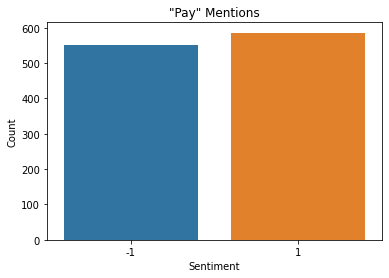

<Figure size 432x288 with 0 Axes>

In [14]:
payDB = df.copy()

payDB['mention_pay'] = payDB['review_text'].apply(lambda x: containsWord(str(x),'pay'))
display(payDB.mention_pay.value_counts())
positivePay = payDB[payDB.review_sentiment == 1].copy()
negativePay = payDB[payDB.review_sentiment == -1].copy()

print(f'Number of "pay" mentions in positive reviews: {len(positivePay[positivePay.mention_pay == 1])}')
print(f'Number of "pay" mentions in negative reviews: {len(negativePay[negativePay.mention_pay == 1])}')

sns.countplot(x='review_sentiment', data=payDB[payDB.mention_pay == 1])
plt.title('\"Pay\" Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

0    60622
1      266
Name: mention_lag, dtype: int64

Number of "lag" mentions in positive reviews: 159
Number of "lag" mentions in negative reviews: 107


<Figure size 432x288 with 0 Axes>

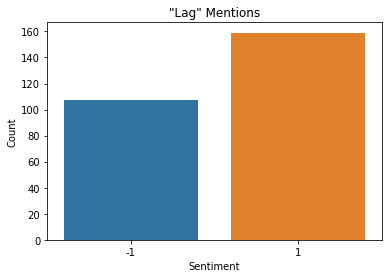

<Figure size 432x288 with 0 Axes>

In [15]:
lagDB = df.copy()

lagDB['mention_lag'] = lagDB['review_text'].apply(lambda x: containsWord(str(x),'lag'))
display(lagDB.mention_lag.value_counts())
positiveLag = lagDB[lagDB.review_sentiment == 1].copy()
negativeLag = lagDB[lagDB.review_sentiment == -1].copy()

print(f'Number of "lag" mentions in positive reviews: {len(positiveLag[positiveLag.mention_lag == 1])}')
print(f'Number of "lag" mentions in negative reviews: {len(negativeLag[negativeLag.mention_lag == 1])}')

sns.countplot(x='review_sentiment', data=lagDB[lagDB.mention_lag == 1])
plt.title('\"Lag\" Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

0    60205
1      683
Name: mention_puzzle, dtype: int64

Number of "puzzle" mentions in positive reviews: 597
Number of "puzzle" mentions in negative reviews: 86


<Figure size 432x288 with 0 Axes>

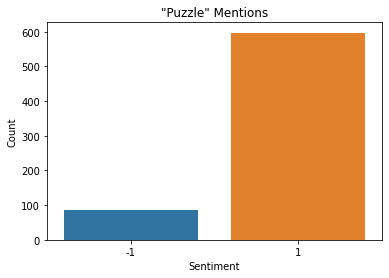

<Figure size 432x288 with 0 Axes>

In [16]:
puzzleDB = df.copy()

puzzleDB['mention_puzzle'] = puzzleDB['review_text'].apply(lambda x: containsWord(str(x),'puzzle'))
display(puzzleDB.mention_puzzle.value_counts())
positivePuzzle = puzzleDB[puzzleDB.review_sentiment == 1].copy()
negativePuzzle = puzzleDB[puzzleDB.review_sentiment == -1].copy()

print(f'Number of "puzzle" mentions in positive reviews: {len(positivePuzzle[positivePuzzle.mention_puzzle == 1])}')
print(f'Number of "puzzle" mentions in negative reviews: {len(negativePuzzle[negativePuzzle.mention_puzzle == 1])}')

sns.countplot(x='review_sentiment', data=puzzleDB[puzzleDB.mention_puzzle == 1])
plt.title('\"Puzzle\" Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

0    60094
1      794
Name: mention_art, dtype: int64

Number of "art" mentions in positive reviews: 675
Number of "art" mentions in negative reviews: 119


<Figure size 432x288 with 0 Axes>

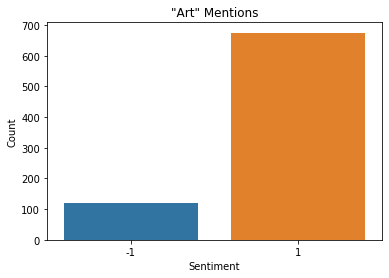

<Figure size 432x288 with 0 Axes>

In [17]:
artDB = df.copy()

artDB['mention_art'] = artDB['review_text'].apply(lambda x: containsWord(str(x),'art'))
display(artDB.mention_art.value_counts())
positiveArt = artDB[artDB.review_sentiment == 1].copy()
negativeArt = artDB[artDB.review_sentiment == -1].copy()

print(f'Number of "art" mentions in positive reviews: {len(positiveArt[positiveArt.mention_art == 1])}')
print(f'Number of "art" mentions in negative reviews: {len(negativeArt[negativeArt.mention_art == 1])}')

sns.countplot(x='review_sentiment', data=artDB[artDB.mention_art == 1])
plt.title('\"Art\" Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

In [18]:
# Top 10 words in the database (neutral words)
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))

stop.update(["br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "go", "lot", "every",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever","amazing","lot","1010","go","every","got", "little",
             "nice", "say", "think", "bit", "awesome",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "doesn't","use","bad","go","could","every","got",
             "see","back",
             ])
# Could add more stopwords to the list

# Help with removing stopwords from https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
# Help with removing punctuation from https://www.codegrepper.com/code-examples/python/remove+punctuation+in+python
top_10_freq = pd.Series(' '.join(df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower().strip().translate(str.maketrans('', '', string.punctuation)) not in (stop)]))).lower().translate(str.maketrans('', '', string.punctuation)).split()).value_counts()[:10]
print(top_10_freq)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time        10184
story        8085
make         5629
gameplay     5084
new          5063
buy          4985
hours        4843
pretty       4036
graphics     3842
things       3494
dtype: int64


In [19]:
# Top 10 words in the POSITIVE database
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))

stop.update(["br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "go", "lot", "every",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever","amazing","lot","1010","go","every","got", "little",
             "nice", "say", "think", "bit", "awesome",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "doesn't","use","bad","go","could","every","got",
             "see","back",
             ])
# Could add more stopwords to the list

# Help with removing stopwords from https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
# Help with removing punctuation from https://www.codegrepper.com/code-examples/python/remove+punctuation+in+python
top_10_freq = pd.Series(' '.join(df[df['review_sentiment'] == 1]['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower().strip().translate(str.maketrans('', '', string.punctuation)) not in (stop)]))).lower().translate(str.maketrans('', '', string.punctuation)).split()).value_counts()[:10]
print(top_10_freq)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time        7401
story       6901
make        4144
gameplay    4140
hours       3895
new         3892
buy         3518
pretty      3230
graphics    3117
things      2717
dtype: int64


In [20]:
# Top 10 words in the NEGATIVE database
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))

stop.update(["br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "go", "lot", "every",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever","amazing","lot","1010","go","every","got", "little",
             "nice", "say", "think", "bit", "awesome",
             "br", "href","game","i","the","like","get","one","good","play","really","game","great","would",
             "games","dont","even","since","start","1","fun","much","best","isnt","quite","overall","end",
             "well","played","app","first","love","still","also","playing","want","im","way","2","ive","better",
             "cant","people","recommend","many","worth","ever", "doesn't","use","bad","go","could","every","got",
             "see","back",
             ])
# Could add more stopwords to the list

# Help with removing stopwords from https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
# Help with removing punctuation from https://www.codegrepper.com/code-examples/python/remove+punctuation+in+python
top_10_freq = pd.Series(' '.join(df[df['review_sentiment'] == -1]['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower().strip().translate(str.maketrans('', '', string.punctuation)) not in (stop)]))).lower().translate(str.maketrans('', '', string.punctuation)).split()).value_counts()[:10]
print(top_10_freq)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
time        2783
make        1485
buy         1467
doesnt      1308
money       1255
work        1196
story       1184
new         1171
hours        948
gameplay     944
dtype: int64


0    55243
1     5645
Name: mention_time, dtype: int64

Number of "time" mentions in positive reviews: 4095
Number of "time" mentions in negative reviews: 1550


0    56522
1     4366
Name: mention_story, dtype: int64

Number of "story" mentions in positive reviews: 3742
Number of "story" mentions in negative reviews: 624
AxesSubplot(0.125,0.125;0.775x0.755)


0    56488
1     4400
Name: mention_make, dtype: int64

Number of "make" mentions in positive reviews: 3254
Number of "make" mentions in negative reviews: 1146


0    57895
1     2993
Name: mention_gameplay, dtype: int64

Number of "gameplay" mentions in positive reviews: 2442
Number of "gameplay" mentions in negative reviews: 551


<Figure size 432x288 with 0 Axes>

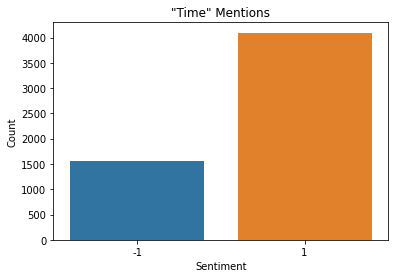

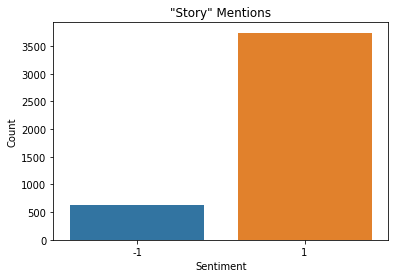

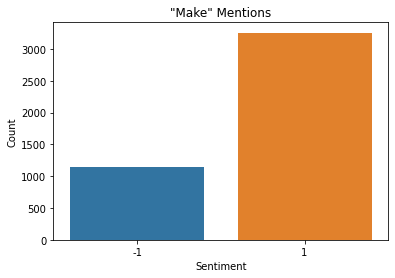

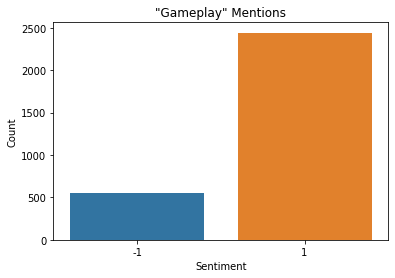

<Figure size 432x288 with 0 Axes>

In [21]:
# Top 4 words analyzed

# Time
timeDB = df.copy()

timeDB['mention_time'] = timeDB['review_text'].apply(lambda x: containsWord(str(x),'time'))
display(timeDB.mention_time.value_counts())
positiveTime = timeDB[timeDB.review_sentiment == 1].copy()
negativeTime = timeDB[timeDB.review_sentiment == -1].copy()

print(f'Number of "time" mentions in positive reviews: {len(positiveTime[positiveTime.mention_time == 1])}')
print(f'Number of "time" mentions in negative reviews: {len(negativeTime[negativeTime.mention_time == 1])}')

# timeDB = timeDB.groupby('review_sentiment').size().reset_index(name='count')
sns.countplot(x='review_sentiment', data=timeDB[timeDB.mention_time == 1])
plt.title('\"Time\" Mentions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()


# Story
storyDB = df.copy()

storyDB['mention_story'] = storyDB['review_text'].apply(lambda x: containsWord(str(x),'story'))
display(storyDB.mention_story.value_counts())
positiveStory = storyDB[storyDB.review_sentiment == 1].copy()
negativeStory = storyDB[storyDB.review_sentiment == -1].copy()

print(f'Number of "story" mentions in positive reviews: {len(positiveStory[positiveStory.mention_story == 1])}')
print(f'Number of "story" mentions in negative reviews: {len(negativeStory[negativeStory.mention_story == 1])}')

plt.title('\"Story\" Mentions')
print(sns.countplot(x='review_sentiment', data=storyDB[storyDB.mention_story == 1]))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

# Make
makeDB = df.copy()

makeDB['mention_make'] = makeDB['review_text'].apply(lambda x: containsWord(str(x),'make'))
display(makeDB.mention_make.value_counts())
positiveMake = makeDB[makeDB.review_sentiment == 1].copy()
negativeMake = makeDB[makeDB.review_sentiment == -1].copy()

print(f'Number of "make" mentions in positive reviews: {len(positiveMake[positiveMake.mention_make == 1])}')
print(f'Number of "make" mentions in negative reviews: {len(negativeMake[negativeMake.mention_make == 1])}')

plt.title('\"Make\" Mentions')
display(sns.countplot(x='review_sentiment', data=makeDB[makeDB.mention_make == 1]))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

# Gameplay
gameplayDB = df.copy()

gameplayDB['mention_gameplay'] = gameplayDB['review_text'].apply(lambda x: containsWord(str(x),'gameplay'))
display(gameplayDB.mention_gameplay.value_counts())
positiveGameplay = gameplayDB[gameplayDB.review_sentiment == 1].copy()
negativeGameplay = gameplayDB[gameplayDB.review_sentiment == -1].copy()

print(f'Number of "gameplay" mentions in positive reviews: {len(positiveGameplay[positiveGameplay.mention_gameplay == 1])}')
print(f'Number of "gameplay" mentions in negative reviews: {len(negativeGameplay[negativeGameplay.mention_gameplay == 1])}')

plt.title('\"Gameplay\" Mentions')
display(sns.countplot(x='review_sentiment', data=gameplayDB[gameplayDB.mention_gameplay == 1]))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

0    59295
1     1593
Name: mention_money, dtype: int64

Number of "money" mentions in positive reviews: 812
Number of "money" mentions in negative reviews: 781


<Figure size 432x288 with 0 Axes>

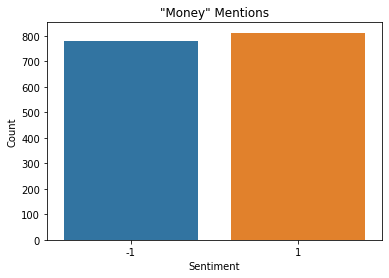

<Figure size 432x288 with 0 Axes>

In [22]:
# Money
moneyDB = df.copy()

moneyDB['mention_money'] = moneyDB['review_text'].apply(lambda x: containsWord(str(x),'money'))
display(moneyDB.mention_money.value_counts())
positiveMoney = moneyDB[moneyDB.review_sentiment == 1].copy()
negativeMoney = moneyDB[moneyDB.review_sentiment == -1].copy()

print(f'Number of "money" mentions in positive reviews: {len(positiveMoney[positiveMoney.mention_money == 1])}')
print(f'Number of "money" mentions in negative reviews: {len(negativeMoney[negativeMoney.mention_money == 1])}')

plt.title('\"Money\" Mentions')
display(sns.countplot(x='review_sentiment', data=moneyDB[moneyDB.mention_money == 1]))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.figure()

## How many games are in our dataset?

In [23]:
df_reviews_by_game = df.groupby('app').size().reset_index(name='number_of_reviews')
df_reviews_by_game = df_reviews_by_game.sort_values("number_of_reviews", ascending=False)
df_reviews_by_game.head(10)

,app,number_of_reviews
2631,PAYDAY 2,858
3650,Terraria,822
4417,com.appxy.planner,800
4414,cc.forestapp,800
4415,com.anydo,800
4416,com.appgenix.bizcal,800
4419,com.gmail.jmartindev.timetune,800
4421,com.habitrpg.android.habitica,800
4423,com.microsoft.todos,800
4426,com.ticktick.task,800


In [24]:
print(len(df_reviews_by_game))

4464


looks like 4,464 games in this dataset

# Preprocessing

In [25]:
def preprocess_review(df_orig):
  df = df_orig.copy()

  # lowercase
  df["review_text"] = df["review_text"].str.lower()

  # remove urls
  df['review_text'] = df['review_text'].apply(lambda x: re.sub(r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)", "", x))

  # remove punctuation
  df['review_text'] = df['review_text'].apply(lambda x: "".join([i for i in x if i not in string.punctuation]))

  # tokenize
  df['review_text'] = df['review_text'].str.split()

  # lemmatize text
  df['review_text'] = df['review_text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])

  # remove stop words
  df['review_text'] = df['review_text'].apply(lambda x: [i for i in x if i not in stopwrds])

  # return back to normal string
  df['review_text'] = df['review_text'].apply(lambda x: ' '.join(x))

  return df

In [26]:
df = pd.read_csv('merged_database.csv')
df.dropna(subset=['review_text'], inplace=True)
df = preprocess_review(df)
df.head()

,app,review_text,review_sentiment,store
0,"!""We Are The Dwarves""!",pretty nice innovative interesting blend defin...,1,steam
1,#SelfieTennis,tennis court house watch lamp hanging ceiling ...,1,steam
2,0RBITALIS,gamer gourment choose game second review steam...,1,steam
3,1 Moment Of Time: Silentville,alright first review think 1 moment time hidde...,1,steam
4,10 Second Ninja,wa like try see demo buying wa demo youtube vi...,-1,steam


In [27]:
y = df["review_sentiment"]
X = df.drop("review_sentiment", axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [29]:
X_train.head()

,app,review_text,store
28522,No Man's Sky,fantastic game lonely exploration accurate des...,steam
7640,Chivalry: Medieval Warfare,name ironic chivalry game,steam
7731,Choice of Robots,tldr fov slide 510 full review since choose ad...,steam
45128,Total Annihilation,love game remember found cd wa like 8 19 still...,steam
50381,theHunter: Primal,sat inventory waiting updated playable theyve ...,steam


# Naive Bayes

get the 200 most common words

In [30]:
all_words = [w.split() for w in X_train["review_text"]]
all_words = [i for sublist in all_words for i in sublist]
common_words = nltk.FreqDist(all_words)
common_words = {k: v for k, v in sorted(common_words.items(), key=lambda item: item[1], reverse=True)}
word_features = list(common_words)[:200]

In [31]:
def document_features(document):
  document_words = set(document.split())
  features = {}
  for word in word_features:
      features[f'({word})'] = (word in document_words)
  return features

In [32]:
training_features = []
testing_features = []
for ((index, row), label) in zip(X_train.iterrows(), y_train):
  training_features.append((document_features(row["review_text"]), label))

for ((index, row), label) in zip(X_test.iterrows(), y_test):
  testing_features.append((document_features(row["review_text"]), label))

In [33]:
classifier = nltk.NaiveBayesClassifier.train(training_features)
print(classifier.show_most_informative_features(n=30))

Most Informative Features
                  (1010) = True                1 : -1     =      8.8 : 1.0
               (awesome) = True                1 : -1     =      4.6 : 1.0
               (amazing) = True                1 : -1     =      4.5 : 1.0
                  (best) = True                1 : -1     =      4.0 : 1.0
                (repeat) = True               -1 : 1      =      3.5 : 1.0
                  (task) = True               -1 : 1      =      3.0 : 1.0
                 (money) = True               -1 : 1      =      2.8 : 1.0
                   (app) = True               -1 : 1      =      2.8 : 1.0
            (definitely) = True                1 : -1     =      2.7 : 1.0
                  (cant) = True               -1 : 1      =      2.6 : 1.0
                (update) = True               -1 : 1      =      2.6 : 1.0
               (version) = True               -1 : 1      =      2.5 : 1.0
               (nothing) = True               -1 : 1      =      2.5 : 1.0

In [34]:
y_true = list(list(zip(*testing_features))[1])
test_features = list(list(zip(*testing_features))[0])
y_predict = [classifier.classify(features) for features in test_features]

(p, r, f, s) = precision_recall_fscore_support(y_true, y_predict)
(_, _, weighted_f, _) = precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('\n')
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F1: {f}")
print(f"Weighted F1: {weighted_f}")
print(f"Support: {s}")



Precision: [0.55515239 0.83850171]
Recall: [0.37918216 0.9138561 ]
F1: [0.45059638 0.87455872]
Weighted F1: 0.7809096229376105
Support: [ 4035 14232]


# LSTM

In [35]:
MAX_FEATURES = 2000
MAX_LEN = 50
EMBED_DIM = 128

In [36]:
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

In [37]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(X_train['review_text'].values)
sequences = tokenizer.texts_to_sequences(X_train["review_text"].values)
X_train_sequence = pad_sequences(sequences, maxlen=MAX_LEN)

In [38]:
test_sequences = tokenizer.texts_to_sequences(X_test["review_text"].values)
X_test_sequence = pad_sequences(test_sequences, maxlen=MAX_LEN)

In [39]:
embedding_layer = Embedding(
  MAX_FEATURES,
  EMBED_DIM,
  input_length=MAX_LEN,
  trainable=True)

In [40]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 309,633
Trainable params: 309,633
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [42]:
history = model.fit(
  X_train_sequence, y_train,
  batch_size=64,
  epochs=5,
  validation_data=[X_test_sequence, y_test],
  verbose=1,
)

Epoch 1/5
666/666 [==============================] - 21s 20ms/step - loss: 0.3567 - accuracy: 0.8497 - val_loss: 0.3046 - val_accuracy: 0.8721
Epoch 2/5
666/666 [==============================] - 12s 19ms/step - loss: 0.2879 - accuracy: 0.8810 - val_loss: 0.3045 - val_accuracy: 0.8728
Epoch 3/5
666/666 [==============================] - 13s 20ms/step - loss: 0.2661 - accuracy: 0.8903 - val_loss: 0.3130 - val_accuracy: 0.8747
Epoch 4/5
666/666 [==============================] - 12s 18ms/step - loss: 0.2442 - accuracy: 0.8989 - val_loss: 0.3181 - val_accuracy: 0.8636
Epoch 5/5
666/666 [==============================] - 13s 20ms/step - loss: 0.2249 - accuracy: 0.9074 - val_loss: 0.3348 - val_accuracy: 0.8699


In [43]:
CUTOFF = 0.7

In [44]:
y_predict = model.predict(X_test_sequence)
y_classes = np.where(y_predict > CUTOFF, 1, 0)

In [45]:
(p,r,f,s) = precision_recall_fscore_support(y_test, y_classes)
(_, _, weighted_f, _) = precision_recall_fscore_support(y_test, y_classes, average='weighted')
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F1: {f}")
print(f"Weighted F1: {weighted_f}")
print(f"Support: {s}")

Precision: [0.6303542  0.92737305]
Recall: [0.75861214 0.87387577]
F1: [0.68856147 0.89982998]
Weighted F1: 0.8531628468108039
Support: [ 4035 14232]


# Real Time Prediction

## Games we want to look at

In [46]:
games_to_predict = [
  # {'game': 'gran-turismo-7', 'platform': 'playstation-5'},
  # {'game': 'elden-ring', 'platform': 'playstation-5'},
  {'game': 'xeodrifter', 'platform': 'switch'}
]

## Clean text

In [47]:
def is_review_in_another_language(texts):
  # Korean
  if re.search("[\uac00-\ud7a3]", texts):
    return True
  # Japanese
  if re.search("[\u3040-\u30ff]", texts):
    return True
  # Chinese
  if re.search("[\u4e00-\u9FFF]", texts):
    return True
  # Cyrillic 
  if re.search('[\u0400-\u04FF]', texts):
    return True

  return False

In [48]:
printable = set(string.printable)

def clean_web(text):
  text = text.replace('\r', ' ')
  text = text.replace('\r\n', ' ')
  text = text.replace('\n', ' ')
  text = text.replace('’', '\'')
  text = text.replace('‘', '\'')
  return ''.join(filter(lambda x: x in printable, text))

## Prediction

Scraping data for: xeodrifter


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


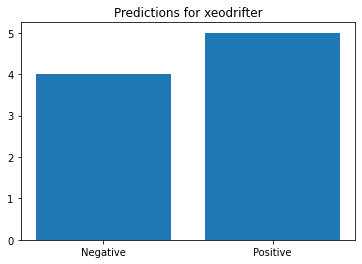

In [49]:
for game in games_to_predict:
  print(f"Scraping data for: {game['game']}")
  review_dict = {
    'name':[],
    'date':[],
    'rating':[],
    'review_text':[]
  }

  url = f"https://www.metacritic.com/game/{game['platform']}/{game['game']}/user-reviews"

  user_agent = {'User-agent': 'Mozilla/5.0'}
  response  = requests.get(f'{url}?page=0', headers = user_agent)
  soup = BeautifulSoup(response.text, 'html.parser')
  lastPage = soup.find('li',class_='page last_page')
  pageInt = 1
  try:
    pageInt = int(lastPage.text.strip("…"))
  except:
    pass

  for page in tqdm(range(pageInt)):
    response = requests.get(f'{url}?page={page}', headers=user_agent)
    soup = BeautifulSoup(response.text, 'html.parser')
    for review in soup.find_all('div', class_='review_content'):
      if review.find('div', class_='name') == None:
        break

      added_review = False
      if review.find('span', class_='blurb blurb_expanded'):
        found_review = review.find('span', class_='blurb blurb_expanded')
        if found_review and not is_review_in_another_language(found_review.text):
          added_review = True
          review_dict['review_text'].append(clean_web(found_review.text))
      else:
        found_review = review.find('div', class_='review_body').find('span')
        if found_review and not is_review_in_another_language(found_review.text):
          added_review = True
          review_dict['review_text'].append(clean_web(found_review.text))

      if added_review:
        review_dict['name'].append(review.find('div', class_='name').find('a').text.strip())
        review_dict['date'].append(review.find('div', class_='date').text.strip())
        review_dict['rating'].append(review.find('div', class_='review_grade').find_all('div')[0].text.strip())

  # can save reviews off here if you want
  reviews = pd.DataFrame(review_dict)
  reviews.dropna(subset=['review_text'], inplace=True)
  reviews = preprocess_review(reviews)
  review_sequences = tokenizer.texts_to_sequences(reviews["review_text"].values)
  review_test_sequence = pad_sequences(review_sequences, maxlen=MAX_LEN)
  y_predict = model.predict(review_test_sequence)
  y_classes = np.where(y_predict > CUTOFF, 1, 0)
  y_counter = Counter(y_classes.flatten())

  plt.title(f"Predictions for {game['game']}")
  d = {'Negative': y_counter[0], 'Positive': y_counter[1]}
  plt.bar(*zip(*d.items()))
  plt.show()

